<a href="https://colab.research.google.com/github/antoinexp/matrix-gradient-descent-dynamic/blob/main/gradient-descent-dynamic-experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.special as special
from IPython import display
from itertools import product
from scipy.integrate import quad, dblquad
from scipy.misc import derivative
import matplotlib as mpl
print(tf.test.gpu_device_name())
tf.device('/device:GPU:0')

/device:GPU:0


### Theoritical equations

In [ ]:
def nexp_hat_q0(alpha, _lambda, t):
  beta = (1+1/_lambda)
  lroot = _lambda**0.5
  r = quad(lambda s: (
        np.where(s>0, np.exp((2/lroot-beta)*s)*special.i1e(2*s/lroot)*lroot/s, 1.)
      ), 0., t)[0]
  return alpha*(1 - r/_lambda)

def nexp_hat_p0(alpha, _lambda, t):
  beta = (1+1/_lambda)
  lroot = _lambda**0.5

  r1 = quad(lambda s: 
            nexp_hat_q0(alpha, _lambda, s)*
            np.where(2*t-s>0., (
                np.exp((2/lroot-beta)*(2*t-s))*
                special.i1e(2*(2*t-s)/lroot)*lroot/(2*t-s)
            ), 1.)
            , 0., t)[0]

  r2 = dblquad(lambda u,v: 
              nexp_hat_q0(alpha, _lambda, u)*
              nexp_hat_q0(alpha, _lambda, v)*
              np.where(2*t-u-v>0., (
                  np.exp((2/lroot-beta)*(2*t-u-v))*
                  special.i1e(2*(2*t-u-v)/lroot)*lroot/(2*t-u-v)
              ), 1.)
              , 0., t, 0., t)[0]

  r0 = np.where(t>0, np.exp((2/lroot-beta)*(2*t))*special.i1e(2*(2*t)/lroot)*lroot/(2*t), 1.)

  return (r0 + 2*alpha*r1 + r2)

def nexp_q0(alpha, _lambda, t):
  a = nexp_hat_q0(alpha, _lambda, t)
  b = nexp_hat_p0(alpha, _lambda, t)**0.5
  return a/b

In [ ]:
def th_risk(alpha, _lambda, t):
  beta = (1+1/_lambda)
  def _(t):
    return beta+0.5*derivative(lambda s: np.log(nexp_hat_p0(alpha, _lambda, s)), t, dx=1e-6)
  return np.vectorize(_)(t)

In [ ]:
# special case when lambda=1
def h_q0_1(alpha, t):
  return alpha*(special.i1e(2*t) + special.i0e(2*t))

def h_p0_1(alpha, t):

  r1 = quad(lambda s: (
              h_q0_1(alpha, s)*
              np.where(2*t-s>0, special.i1e(2*(2*t-s))/(2*t-s), 1.)
            ), 0., t)[0]

  r2 = dblquad(lambda u,v: (
                h_q0_1(alpha, u)*
                h_q0_1(alpha, v)*
                np.where(2*t-u-v>0, special.i1e(2*(2*t-u-v))/(2*t-u-v), 1.)
              ), 0., t, 0., t)[0]

  r0 = np.where(t>0, special.i1e(2*(2*t))/(2*t), 1.)

  return (r0 + 2*alpha*r1 + r2)

def q0_1(alpha, t):
  a = h_q0_1(alpha, t)
  b = h_p0_1(alpha, t)**0.5
  return a/b

In [ ]:
# only for negative _lambda, the following expression works better numerically with floats precision issues
def neg_hat_q0(alpha, _lambda, t):
  beta = (1+1/_lambda)
  lroot = _lambda**0.5
  r = quad(lambda theta: (
        np.exp( ((2/lroot)*np.cos(theta)-beta)*t )*(1-np.cos(2*theta))/(beta-(2./lroot)*np.cos(theta))
      ), 0., np.pi)[0]
  return (alpha/(np.pi*_lambda))*r

def neg_hat_p0(alpha, _lambda, t):
  beta = (1+1/_lambda)
  lroot = _lambda**0.5

  r1 = quad(lambda s: 
            neg_hat_q0(alpha, _lambda, s)*
            np.where(2*t-s>0., (
                np.exp((2/lroot-beta)*(2*t-s))*
                special.i1e(2*(2*t-s)/lroot)*lroot/(2*t-s)
            ), 1.)
            , 0., t)[0]

  r2 = dblquad(lambda u,v: 
              neg_hat_q0(alpha, _lambda, u)*
              neg_hat_q0(alpha, _lambda, v)*
              np.where(2*t-u-v>0., (
                  np.exp((2/lroot-beta)*(2*t-u-v))*
                  special.i1e(2*(2*t-u-v)/lroot)*lroot/(2*t-u-v)
              ), 1.)
              , 0., t, 0., t)[0]

  r0 = np.where(t>0, np.exp((2/lroot-beta)*(2*t))*special.i1e(2*(2*t)/lroot)*lroot/(2*t), 1.)

  return (r0 + 2*alpha*r1 + r2)

def neg_q0(alpha, _lambda, t):
  a = neg_hat_q0(alpha, _lambda, t)
  b = neg_hat_p0(alpha, _lambda, t)**0.5
  return a/b

### Experimental Model 

In [ ]:
class Model(tf.Module):
  def __init__(self, a0=0.1, N=100, _lambda=100., fixed_init=False):
    self._N = N
    self._lambda = _lambda
    self.a0 = a0

    if fixed_init:
      e_1 = np.zeros((N,))
      e_1[0] = 1.

      e_alpha = np.zeros((N,))
      e_alpha[0] = a0
      e_alpha[1] = (1.-a0**2.)**0.5

      self._theta_star = tf.constant((N**0.5)*e_1, dtype="float32")
      self._theta = tf.Variable((N**0.5)*e_alpha, dtype="float32")
    else:
      COV = tf.constant([[1.0, a0], [a0, 1.0]])
      A = tf.linalg.cholesky(COV)
      Z = tf.random.normal((2,N,))
      Z = tf.tensordot(A, Z, 1)
      Z = (N**0.5)*tf.math.l2_normalize(Z, axis=1)
      #print(tf.tensordot(Z, tf.transpose(Z), 1).numpy()/N)
      self._theta_star = tf.constant(Z[0,:])
      self._theta = tf.Variable(Z[1,:])


    TMP = tf.random.normal((N,N))
    self._Xi = tf.constant( (TMP + tf.transpose(TMP))/(2.**0.5) )

  @tf.function
  def __call__(self):
    return tf.tensordot(self._theta, self._theta, 0)

  @tf.function
  def eigenvalues(self):
    e, v = tf.linalg.eigh(self.Y())
    return e, v

  @tf.function
  def Y(self):
    signal = tf.tensordot(self._theta_star, self._theta_star, 0)
    noise = ((self._N/self._lambda)**0.5)*self._Xi
    return signal + noise

  @tf.function
  def mse(self):
    error = self.Y()-self()
    return (1./self._N**2.)*(tf.norm(error)**2.)
                             
  @tf.function
  def H(self):
    Y = self.Y()
    return self.mse() - (tf.norm(Y)**2)/(self._N**2.)
  
  def Q(self, z):
    M = tf.cast(((1/self._lambda)**0.5)*(self._Xi/self._N**0.5), "complex64")
    G = tf.linalg.inv(M - z*tf.eye(self._N, dtype="complex64"))
    u = tf.cast(self._theta_star, "complex64")/(model._N**0.5)
    v = tf.cast(self._theta, "complex64")/(model._N**0.5)
    return tf.tensordot(v, tf.tensordot(G, u, 1), 1)

  def Resolvent(self, z):
    M = tf.cast(((1/self._lambda)**0.5)*(self._Xi/self._N**0.5), "complex64")
    G = tf.linalg.inv(M - z*tf.eye(self._N, dtype="complex64"))
    return (1/self._N)*tf.linalg.trace(G)

  def G(self, z):
    root = (z**2-4)**0.5
    if (np.imag(root) < 0 and np.imag(z)>0) or (np.imag(root)>0 and np.imag(z)<0):
      root *= -1
    return 0.5*( -z + root)

  @tf.function
  def q0(self):
    return (1./self._N)*tf.tensordot(self._theta, self._theta_star, 1)

  @tf.function
  def learn(self, dt):
    grad = tf.gradients(self.mse(), self._theta)[0]
    surfgrad = grad - (1./self._N)*tf.tensordot(grad, self._theta, 1)*self._theta
    theta_new = self._theta - dt*self._N*(1./4.)*surfgrad
    theta_new = (self._N**0.5)*tf.math.l2_normalize(theta_new)
    self._theta.assign(theta_new)
    return self.q0()
  
  def th_q0(self, t):
    return np.vectorize(lambda t: nexp_q0(self.a0, self._lambda, t))(t)


### Plots Theoretical Curves

In [ ]:
def plot(alpha):
  LAMBDA_SPACE = np.logspace(2., -0.8, 30)
  T_SPACE = np.logspace(-2, 1., 30)

  res = []
  for _lambda in LAMBDA_SPACE:
    res.append((_lambda, [nexp_q0(alpha, _lambda, t) for t in T_SPACE]))

  norm = mpl.colors.LogNorm(vmin=0.1, vmax=LAMBDA_SPACE.max())
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.twilight_shifted)
  cmap.set_array([])

  fig, ax = plt.subplots(figsize=(8,5))
  for n, (_lambda, Y) in enumerate(res):
    ax.plot(T_SPACE, Y, c=cmap.to_rgba(_lambda))
  ax.grid(True)
  ax.set_xlim(0.,10.)
  ax.set_ylim(0.,1.)

  #ax.plot(T_SPACE, [nexp_q0(alpha, 1., t) for t in T_SPACE], "--", color="darkgreen", label="$\lambda=1$")
  ax.plot(T_SPACE, [q0_1(alpha, t) for t in T_SPACE], "--", color="blue", label="$\lambda=1$")
  ax.legend()

  clb = fig.colorbar(cmap, ticks=[0.1, 1, 10,  100])
  clb.ax.set_yticklabels([0.1, 1, 10,  100])
  clb.ax.set_title('$\lambda$')

  ax.set_xlabel('t (time)')
  ax.set_ylabel('$q(t)$')

  plt.show()

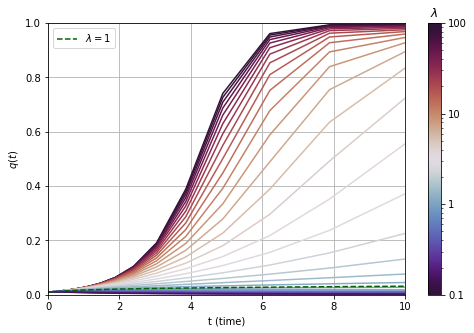

In [ ]:
plot(alpha = 0.01)

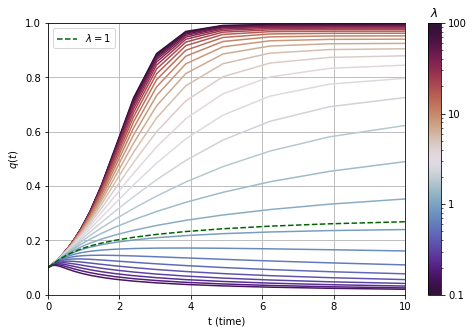

In [ ]:
plot(alpha = 0.1)

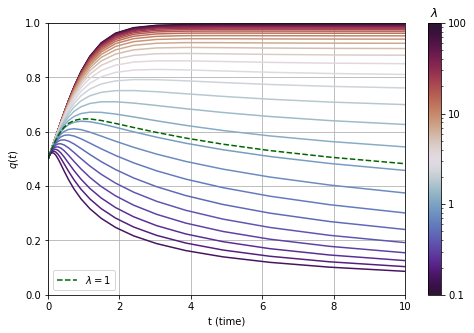

In [ ]:
plot(alpha = 0.5)

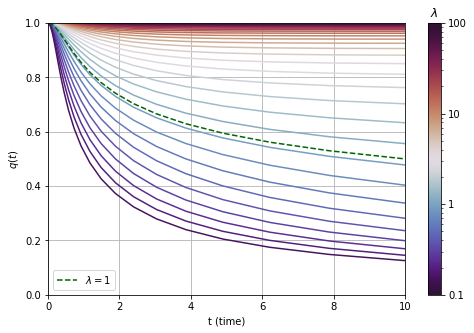

In [ ]:
plot(alpha = 1.0)

In [ ]:
ALPHA_SPACE = np.linspace(0.01, 1., 20)
T_SPACE = np.logspace(-2, 2, 20)

res = [(alpha, [q0_1(alpha, t) for t in T_SPACE]) for alpha in ALPHA_SPACE]

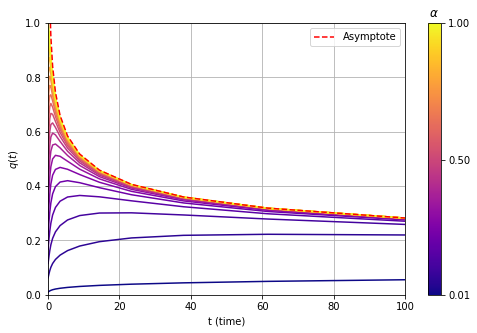

In [ ]:
norm = mpl.colors.Normalize(vmin=ALPHA_SPACE.min(), vmax=ALPHA_SPACE.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

fig, ax = plt.subplots(figsize=(8,5))
for alpha, Y in res:
  ax.plot(T_SPACE, Y, c=cmap.to_rgba(alpha))
ax.plot(T_SPACE, [(np.pi*t/2)**(-1/4) for t in T_SPACE], "r--", label="Asymptote")
plt.legend()
ax.grid(True)
ax.set_xlim(0.,100.)
ax.set_ylim(0.,1.)

clb = fig.colorbar(cmap, ticks=[0.01, 0.5, 1])
#clb.ax.set_yticklabels([0.01, 1])
clb.ax.set_title('$\\alpha$')

ax.set_xlabel('t (time)')
ax.set_ylabel('$q(t)$')

plt.show()

### Plots Theoretical vs Experimental

In [ ]:
def runExperiment(_lambda = 0.8, N = 100, a0 = 0.5, dt=0.1, steps = 200, N_samples = 10):
  plt.axhline(y=np.sqrt(1-1./_lambda), color='r', linestyle='-', label="max theoritical")
  plt.grid(True)
  plt.ylim(0., 1.2)

  T_SPACE = np.linspace(0., (steps)*dt, steps+1)

  ts = []
  ts_risk = []

  for _ in range(N_samples):
    model = Model(a0=a0, N=N, _lambda=_lambda, fixed_init=True)
    print(abs(model.q0().numpy()))
    lq0 = [model.q0()]
    lrisk = [0.5*(model.H() - 1.)]
    for _ in range(steps):
      lq0.append( abs(model.learn(dt).numpy()) )
      lrisk.append(0.5*(model.H() - 1.))
    ts.append(np.asarray(lq0))
    ts_risk.append(np.asarray(lrisk))
    plt.plot(T_SPACE, lq0, "b--", linewidth=0.5)
    display.clear_output(wait=True)
    display.display(plt.gcf())

  ts = np.asarray(ts)
  ts_risk = np.asarray(ts_risk)

  Y_T_SPACE = np.logspace(-2, np.log10((steps)*dt), 30)
  Y = np.vectorize(model.th_q0)(Y_T_SPACE)
  YR = th_risk(model.a0, model._lambda, Y_T_SPACE)

  plt.plot(Y_T_SPACE, Y, "y", linewidth=2)

  display.clear_output(wait=True)

  return T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk

In [ ]:
def plot_q0(_lambda, T_SPACE, Y_T_SPACE, Y, ts):
  plt.figure(figsize=(6,4))

  if _lambda > 1.:
    plt.axhline(y=np.sqrt(1-1./_lambda), color='r', linestyle='--', linewidth=1, label=r"$\lim_t \bar q(t)$")

  tinf = np.quantile(ts, 0.05, axis=0)
  tsup = np.quantile(ts, 0.95, axis=0)
  plt.fill_between(T_SPACE, tinf, tsup, alpha=0.3, label=r"$q(t)$ [5%-95%]")
  plt.plot(T_SPACE, tsup, "b--", alpha=0.3, linewidth=1)
  plt.plot(T_SPACE, tinf, "b--", alpha=0.3, linewidth=1)

  tinf = np.quantile(ts, 0.25, axis=0)
  tsup = np.quantile(ts, 0.75, axis=0)
  plt.fill_between(T_SPACE, tinf, tsup, alpha=0.3, label=r"$q(t)$ [25%-75%]")
  plt.plot(T_SPACE, tsup, "b--", alpha=0.3, linewidth=1)
  plt.plot(T_SPACE, tinf, "b--", alpha=0.3, linewidth=1)

  plt.plot(Y_T_SPACE, Y, linewidth=2, color="g", label=r"$\bar q(t)$")
  plt.ylim(0,1.2)

  plt.xlabel("t (time)")
  plt.ylabel('$q(t)$')

  plt.grid(True)
  plt.legend()
  plt.show()

In [ ]:
def plot_risk(_lambda, T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk):
  plt.figure(figsize=(6,4))

  ts_p1 = -ts_risk - ts**2

  tinf = np.quantile(ts_p1, 0.05, axis=0)
  tsup = np.quantile(ts_p1, 0.95, axis=0)
  plt.fill_between(T_SPACE, tinf, tsup, alpha=0.3, label=r"$ \frac{1}{\sqrt{\lambda}}~p_1(t) $ [5%-95%]")
  plt.plot(T_SPACE, tsup, "b--", alpha=0.3, linewidth=1)
  plt.plot(T_SPACE, tinf, "b--", alpha=0.3, linewidth=1)

  tinf = np.quantile(ts_p1, 0.25, axis=0)
  tsup = np.quantile(ts_p1, 0.75, axis=0)
  plt.fill_between(T_SPACE, tinf, tsup, alpha=0.3, label=r"$ \frac{1}{\sqrt{\lambda}}~p_1(t) $ [25%-75%]")
  plt.plot(T_SPACE, tsup, "b--", alpha=0.3, linewidth=1)
  plt.plot(T_SPACE, tinf, "b--", alpha=0.3, linewidth=1)

  # Risk

  tinf = np.quantile(1+ts_risk, 0.05, axis=0)
  tsup = np.quantile(1+ts_risk, 0.95, axis=0)
  plt.fill_between(T_SPACE, tinf, tsup, alpha=0.3, label=r"$\mathcal{R}(t)$ [5%-95%]")
  plt.plot(T_SPACE, tsup, "b--", alpha=0.3, linewidth=1)
  plt.plot(T_SPACE, tinf, "b--", alpha=0.3, linewidth=1)

  tinf = np.quantile(1+ts_risk, 0.25, axis=0)
  tsup = np.quantile(1+ts_risk, 0.75, axis=0)
  plt.fill_between(T_SPACE, tinf, tsup, alpha=0.3, label=r"$\mathcal{R}(t)$ [25%-75%]")
  plt.plot(T_SPACE, tsup, "b--", alpha=0.3, linewidth=1)
  plt.plot(T_SPACE, tinf, "b--", alpha=0.3, linewidth=1)

  plt.plot(Y_T_SPACE, 1-YR, linewidth=2, color="g", label=r"$\bar \mathcal{R}(t)$")
  plt.plot(Y_T_SPACE, YR-Y**2, linewidth=2, color="grey", label=r"$ \frac{1}{\sqrt{\lambda}}~\bar p_1(t)$")

  if _lambda > 1.:
    plt.axhline(y=-1./_lambda, color='r', linestyle='--', linewidth=1, label=r"$\lim_t \bar \mathcal{R}(t)$")

  plt.xlabel("t (time)")
  #plt.ylim(-2.5, 1.5)

  plt.grid(True)

  plt.legend(loc="lower right") #ncol=2)
  plt.show()

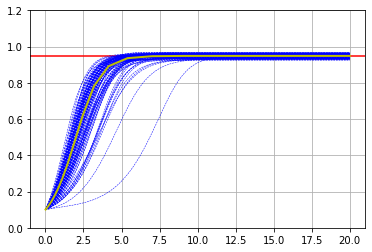

In [ ]:
config = dict(_lambda = 10., N = 70, a0 = 0.1, dt=0.1, steps = 200, N_samples = 100)
T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk = runExperiment(**config)

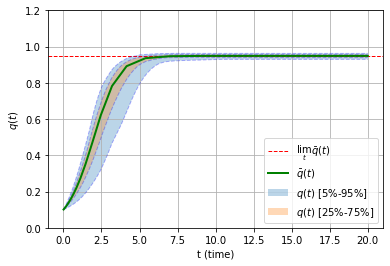

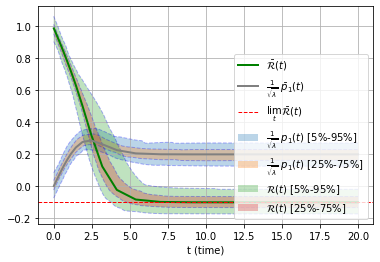

In [ ]:
plot_q0(config["_lambda"], T_SPACE, Y_T_SPACE, Y, ts)
plot_risk(config["_lambda"],T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk)

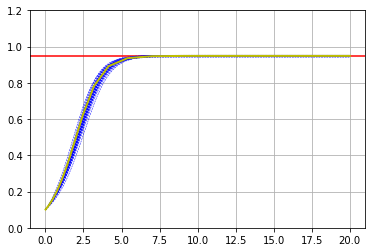

In [ ]:
config = dict(_lambda = 10., N = 1000, a0 = 0.1, dt=0.1, steps = 200, N_samples = 30)
T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk = runExperiment(**config)

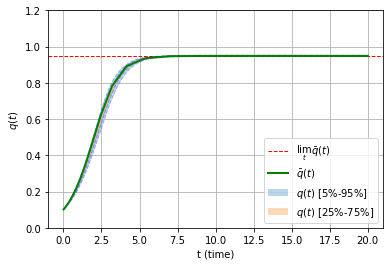

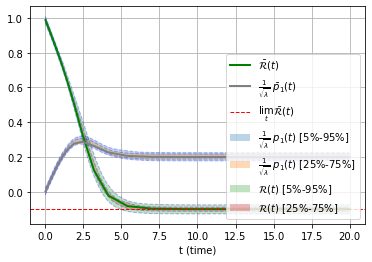

In [ ]:
plot_q0(config["_lambda"], T_SPACE, Y_T_SPACE, Y, ts)
plot_risk(config["_lambda"],T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk)

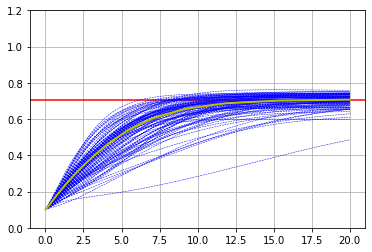

In [ ]:
config = dict(_lambda = 2., N = 1000, a0 = 0.1, dt=0.1, steps = 200, N_samples = 100)
T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk = runExperiment(**config)

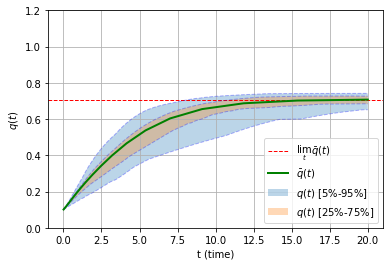

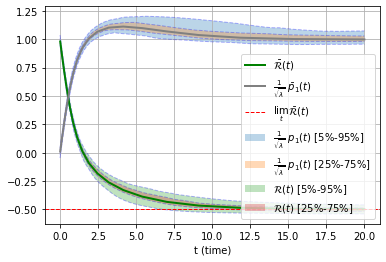

In [ ]:
plot_q0(config["_lambda"], T_SPACE, Y_T_SPACE, Y, ts)
plot_risk(config["_lambda"],T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk)

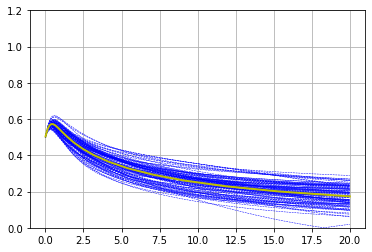

In [ ]:
config = dict(_lambda = 0.5, N = 1000, a0 = 0.5, dt=0.1, steps = 200, N_samples = 100)
T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk = runExperiment(**config)

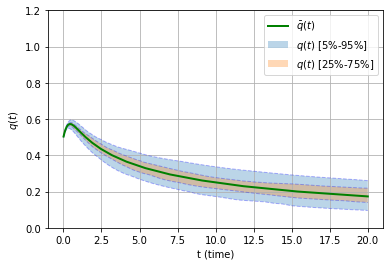

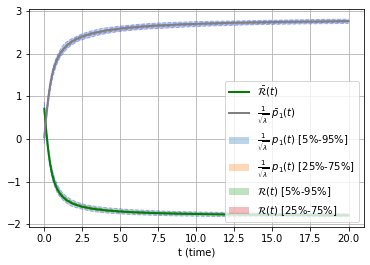

In [ ]:
plot_q0(config["_lambda"], T_SPACE, Y_T_SPACE, Y, ts)
plot_risk(config["_lambda"],T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk)

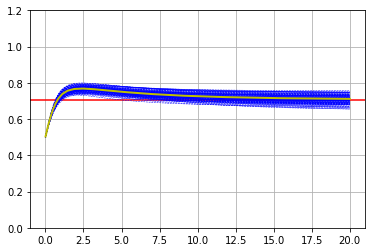

In [ ]:
config = dict(_lambda = 2., N = 1000, a0 = 0.5, dt=0.1, steps = 200, N_samples = 100)
T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk = runExperiment(**config)

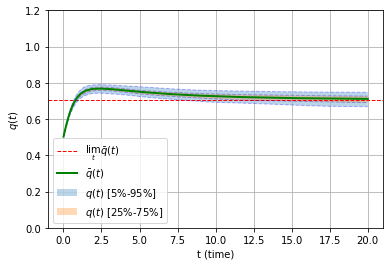

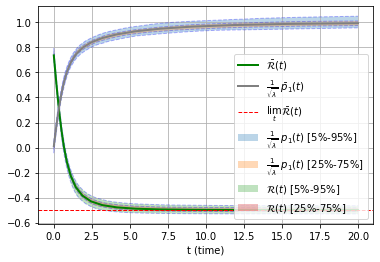

In [ ]:
plot_q0(config["_lambda"], T_SPACE, Y_T_SPACE, Y, ts)
plot_risk(config["_lambda"],T_SPACE, Y_T_SPACE, Y, YR, ts, ts_risk)

### Some theoretical risks

In [ ]:
def plot_risk(_lambda = 0.3, alpha=0.1):
  Y_T_SPACE = np.logspace(-2, np.log10(20), 30)
  Y = np.vectorize(lambda t: nexp_q0(alpha, _lambda, t))(Y_T_SPACE)
  YR = th_risk(alpha, _lambda, Y_T_SPACE)

  plt.stackplot(Y_T_SPACE, -YR+Y**2, -Y**2, labels=[r"$\frac{1}{\sqrt{\lambda}}~\bar p_1(t)$", r"$q_0^2(t)$"], alpha=0.7)
  plt.plot(Y_T_SPACE, -YR, "b--", label=r"$\bar \mathcal{R}(t) - 1$")
  plt.legend()
  plt.xlabel("t (time)")
  plt.ylabel("Risk")
  plt.xlim(0,20)
  plt.ylim(-2.5, 0.)

  plt.grid(True)
  plt.show()

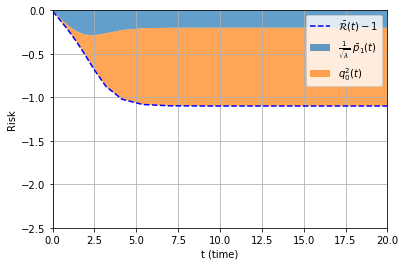

In [ ]:
plot_risk(_lambda = 10, alpha=0.1)

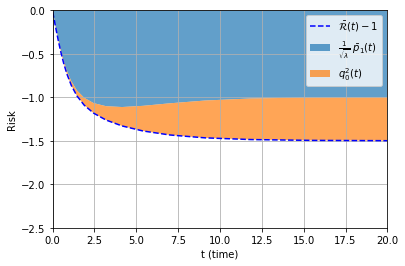

In [ ]:
plot_risk(_lambda = 2, alpha=0.1)

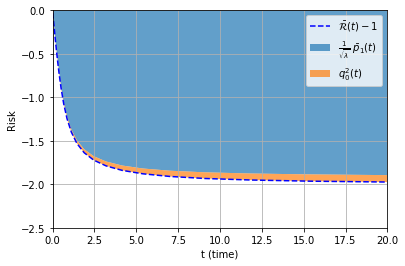

In [ ]:
plot_risk(_lambda = 1, alpha=0.1)

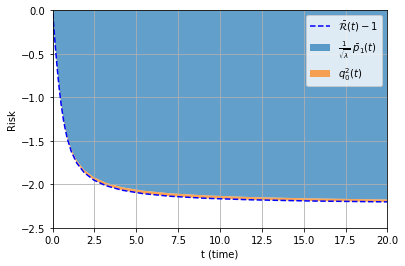

In [ ]:
plot_risk(_lambda = 0.8, alpha=0.1)

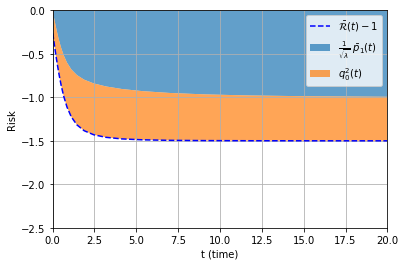

In [ ]:
plot_risk(_lambda = 2.0, alpha=0.5)